## Implement a two-grid scheme using linear interpolation and its transpose as restriction

Import packages

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg
import matplotlib.animation as ani
from matplotlib import rc
from IPython.display import HTML, Image
rc('animation', html='jshtml')
plt.style.use('seaborn')

The matrix below is derived from the finite elements implementation of for the one-dimensional Poisson equation, discretized on a uniform mesh with $n$ unknowns and Dirichlet boundary conditions

In [ ]:
def stiffness(n, dirichlet):
  h = 1/(n-1)
  # A is a tridiagonal matrix with 2/h on the diagonal and -1/h on the off-diagonal
  diagonal = [2/h for i in range(n)]
  diagonal_up = [-1/h for i in range(n-1)]
  diagonal_down = [-1/h for i in range(n-1)]
  A = np.diag(diagonal) + np.diag(diagonal_up, 1) + np.diag(diagonal_down, -1)

  # now enforce the boundary condition
  A[:, 0] = 0
  A[0, :] = 0
  A[0, 0] = 1
  if dirichlet:
    A[:, -1] = 0
    A[-1, :] = 0
    A[n-2, n-2] = 1/h
    A[n-1, n-1] = 1
  else:
    A[n-1, n-1] = 1/h
  return A

Create a function which will accept a matrix and output vector to solve the matrix equation $Ax=b$ using Gauss-Seidel and Weighted Jacobi. This consists of splitting the matrix $A$ into the difference of two matrices, $A=M-N$. For Gauss-Seidel $M=D-L$, where $D$ is the diagonal component of $A$ and $L$ is the lower triangular component of $A$.

This version of the function takes an iteration parameter $k$ instead of error tolerance $\epsilon$. So we will relax i.e. loop $k$ times. At the moment $k=100$. This is based on experiments where the relative reduction in residual norm for Gauss-Seidel slowed down dramatically leaving only smooth modes of the error.

From the last homework we know that Gauss-Seidel alone takes approximately $10^5$ iterations in order to have $||x_{true}-x_k||<{10^{-5}}$ so we will try to beat this

In [ ]:
def GS(A, b, k, x_true, x0):
  # first extract the diagonal entries of A and the triangular parts of A
  D = np.diag(np.diag(A))
  L = np.tril(A, k=-1)
  U = np.triu(A, k=1)

  # the goal of these iterative schemese is to have a matrix M that is easy to invert
  M = D+L
  N = U
  n = len(A)

  # store the resiudals and error at each iteration
  residuals = []
  errors = []
  iterates = []
  residual_norms = []
  error_norms = []
  iterate_norms = []

  # now start the iteration
  xi = x0
  xi1 = np.linalg.solve(M, b) - np.linalg.solve(M, np.matmul(N,xi))
  iterates.append(xi)
  iterates.append(xi1)
  errors.append(xi-x_true)
  errors.append(xi1-x_true)
  residuals.append(np.matmul(A, x_true) - np.matmul(A, xi))
  residuals.append(np.matmul(A, x_true) - np.matmul(A, xi1))
  iterate_norms.append(np.linalg.norm(xi))
  iterate_norms.append(np.linalg.norm(xi1))
  error_norms.append(np.linalg.norm(xi-x_true))
  error_norms.append(np.linalg.norm(xi1-x_true))
  residual_norms.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi)))
  residual_norms.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi1)))

  for i in range(k):
    xi = xi1
    xi1 = np.linalg.solve(M, b) - np.linalg.solve(M, np.matmul(N,xi))
    residuals.append(np.matmul(A, x_true) - np.matmul(A, xi1))
    errors.append(xi1-x_true)
    iterates.append(xi1)
    iterate_norms.append(np.linalg.norm(xi1))
    error_norms.append(np.linalg.norm(xi1-x_true))
    residual_norms.append(np.linalg.norm(np.matmul(A, x_true) - np.matmul(A, xi1)))
  
  # returns the first k approximations and the norm of the residuals and errors
  return iterates, residuals, errors, iterate_norms, residual_norms, error_norms

To implement the two-grid scheme we will follow the sequence of steps given an initial guess $x^{(h,0)}$: 

1. Relax $k$ times on $Ax=b$ on a mesh $\Omega^h$ with mesh spacing $h$ to get an approximate solution free of oscillatory error $x^{(h,k)}$
2. Restrict the residual to course grid $\Omega^{2h}$: $r^{(2h,k)}=P^Tr^{(h,k)}$
3. Solve for the error on course grid: $e^{2h}=(P^TAP)^{-1}r^{(2h,k)}$
4. Correct the solution on the fine grid $\Omega^{h}$: $x^{(h, k+1)}=x^{(h,k)}+Pe^{(2h)}$
5. Relax again on the fine grid $\Omega^h$

### Step 1: Relax $k$ times on $Ax=b$ on a mesh $\Omega^h$ to get an 

approximate solution free of oscillatory error $x^{(h,k)}$

This can be done with the following loop which is performed in the Gauss-Seidel function above: $x^{(h,i)}=x^{(h,i-1)}+Br^{(h,i-1)}$

In [ ]:
n = (2**8)+1
A = stiffness(n, True)
b = np.zeros((n,))
k = 100
x_h_0 = np.random.rand(n)
x_true = np.linalg.solve(A, b)
iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A, b, k, x_true, x_h_0)
# extract the kth iterate, residual, and error
x_h_k, r_h_k, e_h_k = iterates[-1], residuals[-1], errors[-1]

Visualize the oscillatory error being removed first. A visual test to see if our choice of $k=100$ is appropriate

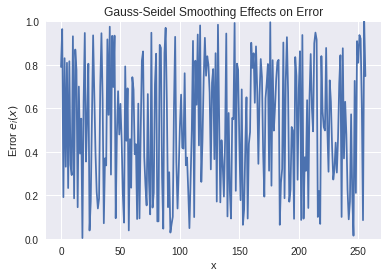

In [ ]:
fig = plt.figure()
def build_plot_GS(i):
    plt.cla()
    if i < len(iterates):
        plt.plot(iterates[i])
        plt.grid(True)
        plt.ylabel('Error $e_i(x)$')
        plt.xlabel('x')
        plt.ylim((0, 1))
        plt.title('Gauss-Seidel Smoothing Effects on Error')

ani.FuncAnimation(fig, build_plot_GS)

Now look at what the last approximation $x^{(h,k)}$ looks like so we can compare and see improvement after the course grid correction

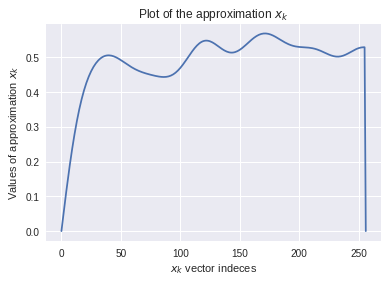

In [ ]:
plt.plot(x_h_k);
plt.title('Plot of the approximation $x_k$');
plt.xlabel('$x_k$ vector indeces');
plt.ylabel('Values of approximation $x_k$');

### Step 2: Restrict the residual to course grid $\Omega^{2h}$: $r^{(2h,k)}=P^Tr^{(h,k)}$

Need to build the restriction operator which is $P^T$

In [ ]:
def interp_restr(n):
  # assumes an odd number of nodes
  restricted_n = int((n-1)/2+1)
  PT = np.zeros((restricted_n, n))
  for i in range(restricted_n):
    if i == 0:
      PT[i, i], PT[i, i+1] = 1, 1/2
    elif i == restricted_n-1:
      PT[i, 2*i-1], PT[i, 2*i] = 1/2, 1
    else:
      PT[i, 2*i-1], PT[i, 2*i], PT[i, 2*i+1] = 1/2, 1, 1/2
  return np.transpose(PT), PT, restricted_n

In [ ]:
P, P_T, _ = interp_restr(n)
r_2h_k = P_T@r_h_k

### Step 3: Solve for the error on course grid: $e^{2h}=(P^TAP)^{-1}r^{(2h,k)}$

In [ ]:
e_2h_k = np.linalg.solve(P_T @ A @ P, r_2h_k)

### Step 4: Correct the solution on the fine grid $\Omega^{h}$: $x^{(h, k+1)}=x^{(h,k)}+Pe^{(2h)}$

In [ ]:
x_h_k1 = x_h_k + P@e_2h_k

Plot $x^{(h,k+1)}$ to see what the effect of the course grid correction is and to give a sense of how much more relaxing we have to do is. We hope to see a significant improvement from before with the solution being close to the true solution $x=0$

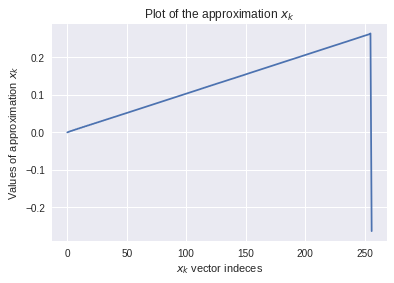

In [ ]:
plt.plot(x_h_k1);
plt.title('Plot of the approximation $x_k$');
plt.xlabel('$x_k$ vector indeces');
plt.ylabel('Values of approximation $x_k$');

### Step 5: Relax $k$ times again on $Ax=b$ on the finer mesh $\Omega^h$

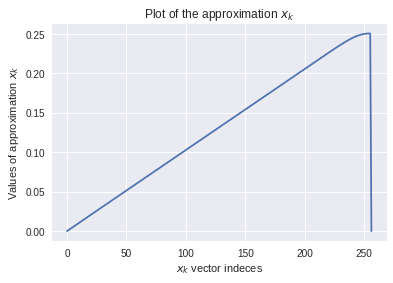

In [ ]:
iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A, b, k, x_true, x_h_k1)
# extract the kth iterate, residual, and error
x_h_l, r_h_l, e_h_l = iterates[-1], residuals[-1], errors[-1]
plt.plot(x_h_l);
plt.title('Plot of the approximation $x_k$');
plt.xlabel('$x_k$ vector indeces');
plt.ylabel('Values of approximation $x_k$');

This is clearly an improvement and closer to the true solution of zero. We will write a loop to iterate through this process of relaxing and course grid correction using smaller values of $k$

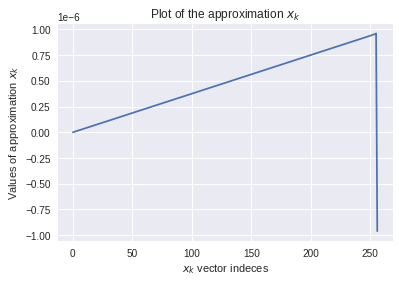

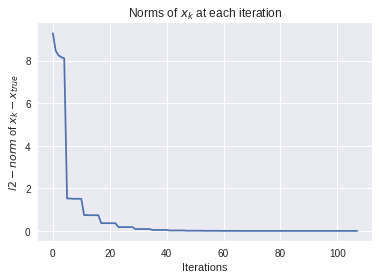

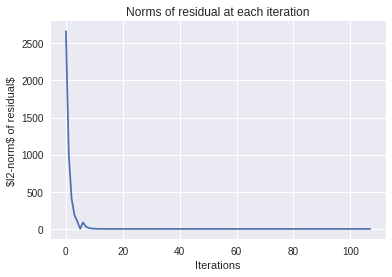

In [ ]:
residuals_list = []
n_list = [2**n+1 for n in range(4, 9)]

for n in n_list:
  A = stiffness(n, True)
  b = np.zeros((n,))
  k = 3
  eps = 10**-5
  x_h_k = np.random.rand(n)
  x_h_k_error_norms = np.array([])
  x_h_k_residual_norms = np.array([])
  x_true = np.linalg.solve(A, b)
  count = 0
  while np.linalg.norm(x_h_k-x_true) > eps:
    iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A, b, k, x_true, x_h_k)
    x_h_k, r_h_k, e_h_k = iterates[-1], residuals[-1], errors[-1]
    x_h_k_error_norms = np.append(x_h_k_error_norms, error_norms)
    x_h_k_residual_norms = np.append(x_h_k_residual_norms, residual_norms)
    P, P_T, _ = interp_restr(n)
    r_2h_k = P_T @ r_h_k
    e_2h_k = np.linalg.solve(P_T @ A @ P, r_2h_k)
    x_h_k = x_h_k + P @ e_2h_k
    x_h_k_error_norms = np.append(x_h_k_error_norms, np.linalg.norm(x_h_k-x_true))
    x_h_k_residual_norms = np.append(x_h_k_residual_norms, np.linalg.norm(x_h_k-x_true))
    count += k
  residuals_list.append(x_h_k_residual_norms)

# plot the final approximation which should be close to zero
plt.figure()
plt.plot(x_h_k);
plt.title('Plot of the approximation $x_k$');
plt.xlabel('$x_k$ vector indeces');
plt.ylabel('Values of approximation $x_k$');

# plot the norm of the errors over time
plt.figure()
plt.plot(x_h_k_error_norms)
plt.title('Norms of $x_k$ at each iteration');
plt.xlabel('Iterations');
plt.ylabel('$l2-norm$ of $x_k-x_{true}$');

# plot the norm of the errors over time
plt.figure()
plt.plot(x_h_k_residual_norms)
plt.title('Norms of residual at each iteration');
plt.xlabel('Iterations');
plt.ylabel('$l2-norm$ of residual$');

This is an incredible improvement over naive Gauss-Seidel. The two-grid scheme converges approximately 4 orders of magnitude faster than using Gauss-Seidel alone to get within $10^{-5}$ of the true solution. Look at the drops in error after each course grid correction! It seems like the relaxation has less and less of an effect after each course grid correction

## Implement a multigrid scheme using linear interpolation and its transpose as restriction

The multigrid v-cycle takes as input:

1. The initial guess $x^{(h,0)}$
2. The vector $b^{(h)}$ in the matrix equation $A^{(h)}x^{(h)}=b^{(h)}$ on the grid $\Omega^{h}$
3. The matrix $A^{(h)}$ in the matrix equation $A^{(h)}x^{(h)}=b^{(h)}$ on the grid $\Omega^{h}$
4. $v_1$ and $v_2$ which are the relaxation parameters

Mutligrid v-cycle follows the following steps:

1.   Relax $v_1$ times on $A^hx^h=b^h$ to produce approximation $x^{(h, 1)}$
2.   If $\Omega^h$ is the next-to-coursest grid, solve for the error $e^{(2h)}=(P_h^TA^hP_h)(b^h-A^hx^{(h,1)})$. Otherwise, continue to call v-cycle and set $e^{(2h)}=v-cycle(0^{(2h)}, P_h^T(b^h-A^hx^{(h,1)}), P_h^TA^hP_h, v_1, v_2)$
3. $x^{(h,2)} = x^{(h,1)} + P_he^{(2h)} $
4. Relax $v_2$ times on $A^hx^h=b^h$ to produce another approximation $x^{(h,3)}$



In [ ]:
n = (2**8)+1
A_h = stiffness(n, True)
b_h = np.zeros((n,))
n_h = len(b_h)
v1 = 5
v2 = 5
eps = 10**-5
x_h_0 = np.random.rand(n)
x_h_k_error_norms = np.array([])
x_true_h = np.linalg.solve(A, b)
count = 0

def v_cycle(x_h_0, b_h, A_h, v1, v2, x_true_h):
  # relax v1 times
  iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A_h, b_h, v1, x_true_h, x_h_0)
  x_h_1 = iterates[-1]
  n_h = len(b_h)
  P_2h, P_2h_T, n_2h = interp_restr(n_h)
  A_2h = P_2h_T @ A_h @ P_2h
  r_2h = P_2h_T @ (b_h - A_h @ x_h_1)
  b_2h = P_2h_T @ b_h
  x_true_2h = P_2h_T @ x_true_h

  # if the grid is course enough do an exact solve. Assumes grid spacing is a power of two
  if n_h == 9:
    e_2h = np.linalg.solve(A_2h, r_2h)
    return e_2h
  else:
    zero_2h = np.zeros((n_2h,))
    e_2h = v_cycle(zero_2h, r_2h, A_2h, v1, v2, x_true_2h)

  P_h, P_h_T, n_course = interp_restr(n_2h)
  # x_h_1 is really e_h_1
  e_h_2 = P_2h_T @ x_h_1 + P_h @ e_2h
  iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A_2h, r_2h, v2, x_true_2h, e_h_2)
  e_h_3 = iterates[-1]

  return e_h_3

In [ ]:
e_h_3 = v_cycle(x_h_0, b_h, A_h, v1, v2, x_true_h)
iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A_h, b_h, v2, x_true_h, x_h_0)
P_2h, P_2h_T, n_2h = interp_restr(n_h)
x_h_2 = iterates[-1] + P_2h @ e_h_3
print(x_h_2)

Use the unwrapped algorithm for multigrid rather than the recursive calls which do not seem to provide estimates that are closer to the true solution

In [ ]:
u_H_0 = np.random.rand(n)
N = (2**8)+1
H = 1/(N-1)
L = 6
eps = 10**-5
A = stiffness(N, True)
b = np.zeros((N,))
u_H_k_error_norms = np.array([])
u_true = np.linalg.solve(A, b)

In [ ]:
while (np.linalg.norm(u_H_0-u_true) > eps):
  N = (2**8)+1
  A_H = stiffness(N, True)
  f_H = np.zeros((N,))
  v1 = 5
  v2 = 5
  u_true_H = np.linalg.solve(A, b)
  count = 0
  interp_array = []
  restr_array = []
  f_H_array = []
  u_H_array = []

  for l in range(L):
    # H = (2**l)*h
    iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A_H, f_H, v1, u_true_H, u_H_0)
    f_H_1 = residuals[-1]
    u_H_1 = iterates[-1]
    f_H_array.append(f_H_1)
    u_H_array.append(u_H_1)

    # get new operators
    P_H, R_H, N = interp_restr(N)
    A_H = R_H @ A_H @ P_H
    u_true_H = R_H @ u_true_H
    interp_array.append(P_H)
    restr_array.append(R_H)
    # restrict residual to courser grid
    f_H = R_H @ f_H_1
    # set next initial approximation to the error to zero
    u_H_0 = np.zeros((N,))

  # H = (2**L)*h, u_H is the error on the coursest grid
  u_H = np.linalg.solve(A_H, f_H)

  for l in reversed(range(1, L)):
    P_H = interp_array[l]
    R_H = restr_array[l]
    u_H_2 = u_H_array[l] + P_H @ u_H
    A_H = P_H @ A_H @ R_H
    f_H = P_H @ f_H
    u_true_H = P_H @ u_true_H
    iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A_H, f_H, v1, u_true_H, u_H_2)
    f_H = residuals[-1]
    u_H = iterates[-1]

  u_H_2 = u_H_array[0] + interp_array[0] @ u_H
  iterates, residuals, errors, iterate_norms, residual_norms, error_norms = GS(A, b, v1, u_true, u_H_2)
  u_H_0 = iterates[-1]

It does not look like multigrid converges, unfortunately. I have implemented it in both the recursive form and the unwrapped loop form and both do not provide an estimate that gets close to the true solution of zero.

## Plot the norms of the residual and error as a function of iterations. Also plot the relative reduction in residual norm per iteration $\frac{||0-Ax^{k}||}{||0-Ax^{(k-1)}||}$

The plots of the norms of the residuals and errors for the two grid scheme are above. Below we look at the relative reduction in residual norm for two grid. This analysis cannot be done for multigrid because the algorithms above do not converge.

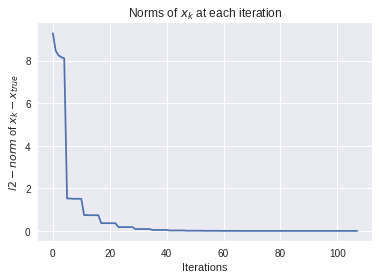

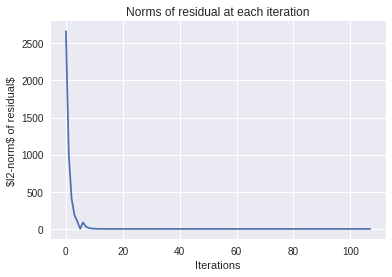

In [ ]:
# plot the norm of the errors over time
plt.figure()
plt.plot(x_h_k_error_norms)
plt.title('Norms of $x_k$ at each iteration');
plt.xlabel('Iterations');
plt.ylabel('$l2-norm$ of $x_k-x_{true}$');

# plot the norm of the errors over time
plt.figure()
plt.plot(x_h_k_residual_norms)
plt.title('Norms of residual at each iteration');
plt.xlabel('Iterations');
plt.ylabel('$l2-norm$ of residual$');

As stated before in problem 1), this is a huge improvment over naive Gauss-Seidel which took approximately $10^5$ iterations to converge within the same tolerance of $10^{-5}$ of zero.

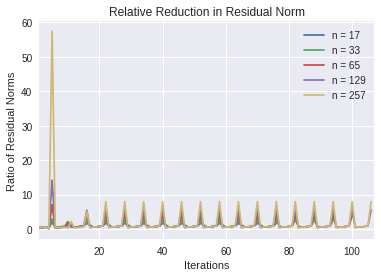

In [ ]:
plt.figure()
for i in range(len(n_list)):
  residuals = residuals_list[i]
  residuals_rel = [residuals[j]/residuals[j-1] for j in range(1, len(residuals))]
  plt.plot(residuals_rel)
  plt.ylabel('Ratio of Residual Norms')
  plt.xlabel('Iterations')
  plt.xlim(1, len(residuals_rel))
  plt.title('Relative Reduction in Residual Norm')
  plt.grid(True)

plt.legend(['n = ' + str(n_list[i]) for i in range(len(n_list))]);

This behavior of the relative reduction in residual norm is very different from naive Gauss-Seidel. Here we see that the reduction is oscillatory whereas for naive Gauss-Seidel it was monotone and the rate of reduction in the residual slowed down after the oscillatory error was removed. For two grid we can see it is relatively constant then spikes when the coarse grid correction is introduced, then relatively constant again. This leads us to believe that two grid has avoided the convergence issues with the "smooth" modes present in naive Gauss-Seidel. This behavior is remarkably consistent across the different mesh-spacings.